In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

2024-02-05 10:07:29.737769: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 10:07:29.737873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 10:07:29.892781: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
PATH = "/kaggle/input/alzheimer-mri-dataset/Dataset/"

BATCH_SIZE = 32
IMG_SIZE = 224

TRAIN_DS = tf.keras.utils.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

VALID_DS = tf.keras.utils.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

CLASSES = TRAIN_DS.class_names

count = np.zeros(len(CLASSES), dtype=np.int32)
for _, labels in TRAIN_DS:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()    
class_weight = dict(enumerate(count))

AUTOTUNE = tf.data.AUTOTUNE

TRAIN_DS = TRAIN_DS.cache().prefetch(buffer_size=AUTOTUNE)
VALID_DS = VALID_DS.cache().prefetch(buffer_size=AUTOTUNE)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [4]:
model = tf.keras.models.Sequential(name="DeepReLUwithEfficientNetB0")
model.add(tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(len(CLASSES), activation='softmax'))
model.layers[0].trainable = False
model.summary()

16705208/16705208 [==============================] - 1s 0us/step
Model: "DeepReLUwithEfficientNetB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 4096)              256905216 
                                                                 
 dense_1 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 64)  

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
training_history = model.fit(TRAIN_DS, validation_data=VALID_DS, epochs=30, class_weight=class_weight)
results = pd.DataFrame({
    "Training Accuracy": training_history.history['accuracy'],
    "Validation Accuracy": training_history.history['val_accuracy'],
    "Training Loss": training_history.history['loss'],
    "Validation Loss": training_history.history['val_loss']
})

Epoch 1/30


2024-02-05 10:08:27.242707: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepReLUwithEfficientNetB0/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707127710.375584      98 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


160/160 [==============================] - 28s 108ms/step - loss: 1747.6926 - accuracy: 0.5611 - val_loss: 1.0625 - val_accuracy: 0.5992
Epoch 2/30
160/160 [==============================] - 13s 83ms/step - loss: 1213.0515 - accuracy: 0.6561 - val_loss: 0.9330 - val_accuracy: 0.6586
Epoch 3/30
160/160 [==============================] - 13s 83ms/step - loss: 1016.2256 - accuracy: 0.7178 - val_loss: 0.7509 - val_accuracy: 0.6969
Epoch 4/30
160/160 [==============================] - 13s 83ms/step - loss: 836.8379 - accuracy: 0.7652 - val_loss: 0.6783 - val_accuracy: 0.7305
Epoch 5/30
160/160 [==============================] - 13s 84ms/step - loss: 740.5279 - accuracy: 0.7930 - val_loss: 0.5992 - val_accuracy: 0.7609
Epoch 6/30
160/160 [==============================] - 14s 85ms/step - loss: 625.0701 - accuracy: 0.8283 - val_loss: 0.5973 - val_accuracy: 0.7750
Epoch 7/30
160/160 [==============================] - 14s 85ms/step - loss: 605.4460 - accuracy: 0.8400 - val_loss: 0.7024 - val_ac

In [6]:
model.layers[0].trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
training_history = model.fit(TRAIN_DS, validation_data=VALID_DS, epochs=15, class_weight=class_weight)
results_unfrozen = pd.DataFrame({
    "Training Accuracy": training_history.history['accuracy'],
    "Validation Accuracy": training_history.history['val_accuracy'],
    "Training Loss": training_history.history['loss'],
    "Validation Loss": training_history.history['val_loss']
})

Epoch 1/15


2024-02-05 10:15:34.613508: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepReLUwithEfficientNetB0/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


160/160 [==============================] - 78s 257ms/step - loss: 1296.4480 - accuracy: 0.6305 - val_loss: 0.8041 - val_accuracy: 0.6453
Epoch 2/15
160/160 [==============================] - 39s 246ms/step - loss: 530.1741 - accuracy: 0.8516 - val_loss: 0.9093 - val_accuracy: 0.6656
Epoch 3/15
160/160 [==============================] - 39s 246ms/step - loss: 285.2955 - accuracy: 0.9262 - val_loss: 0.9554 - val_accuracy: 0.7109
Epoch 4/15
160/160 [==============================] - 39s 247ms/step - loss: 140.8667 - accuracy: 0.9605 - val_loss: 0.6218 - val_accuracy: 0.8211
Epoch 5/15
160/160 [==============================] - 39s 246ms/step - loss: 115.8797 - accuracy: 0.9627 - val_loss: 0.6105 - val_accuracy: 0.8391
Epoch 6/15
160/160 [==============================] - 39s 247ms/step - loss: 89.4116 - accuracy: 0.9723 - val_loss: 0.3307 - val_accuracy: 0.8992
Epoch 7/15
160/160 [==============================] - 39s 244ms/step - loss: 46.2791 - accuracy: 0.9801 - val_loss: 0.5520 - val_

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
training_history = model.fit(TRAIN_DS, validation_data=VALID_DS, epochs=15, class_weight=class_weight)
results_unfrozen_low_lr = pd.DataFrame({
    "Training Accuracy": training_history.history['accuracy'],
    "Validation Accuracy": training_history.history['val_accuracy'],
    "Training Loss": training_history.history['loss'],
    "Validation Loss": training_history.history['val_loss']
})

Epoch 1/15


2024-02-05 10:26:04.880232: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepReLUwithEfficientNetB0/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


160/160 [==============================] - 74s 257ms/step - loss: 15.5505 - accuracy: 0.9967 - val_loss: 0.0863 - val_accuracy: 0.9734
Epoch 2/15
160/160 [==============================] - 40s 250ms/step - loss: 10.9042 - accuracy: 0.9979 - val_loss: 0.0879 - val_accuracy: 0.9711
Epoch 3/15
160/160 [==============================] - 40s 250ms/step - loss: 2.1416 - accuracy: 0.9992 - val_loss: 0.0808 - val_accuracy: 0.9758
Epoch 4/15
160/160 [==============================] - 40s 248ms/step - loss: 3.6791 - accuracy: 0.9992 - val_loss: 0.1035 - val_accuracy: 0.9758
Epoch 5/15
160/160 [==============================] - 40s 250ms/step - loss: 2.8339 - accuracy: 0.9994 - val_loss: 0.0856 - val_accuracy: 0.9742
Epoch 6/15
160/160 [==============================] - 40s 250ms/step - loss: 6.7326 - accuracy: 0.9984 - val_loss: 0.0852 - val_accuracy: 0.9828
Epoch 7/15
160/160 [==============================] - 40s 250ms/step - loss: 5.5398 - accuracy: 0.9988 - val_loss: 0.1281 - val_accuracy: 0

In [8]:
training_history = model.fit(TRAIN_DS, validation_data=VALID_DS, epochs=30, class_weight=class_weight,
                             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights= True, baseline=0.99)])

results_unfrozen_low_lr_final = pd.DataFrame({
    "Training Accuracy": training_history.history['accuracy'],
    "Validation Accuracy": training_history.history['val_accuracy'],
    "Training Loss": training_history.history['loss'],
    "Validation Loss": training_history.history['val_loss']
})

Epoch 1/15
160/160 [==============================] - 43s 267ms/step - loss: 5.7842 - accuracy: 0.9992 - val_loss: 0.1263 - val_accuracy: 0.9711
Epoch 2/15
160/160 [==============================] - 41s 259ms/step - loss: 3.6281 - accuracy: 0.9990 - val_loss: 0.0970 - val_accuracy: 0.9805
Epoch 3/15
160/160 [==============================] - 41s 258ms/step - loss: 3.5063 - accuracy: 0.9992 - val_loss: 0.0676 - val_accuracy: 0.9836
Epoch 4/15
160/160 [==============================] - 41s 258ms/step - loss: 1.6296 - accuracy: 0.9996 - val_loss: 0.0885 - val_accuracy: 0.9797
Epoch 5/15
160/160 [==============================] - 40s 249ms/step - loss: 2.7224 - accuracy: 0.9988 - val_loss: 0.0515 - val_accuracy: 0.9883
Epoch 6/15
160/160 [==============================] - 41s 257ms/step - loss: 1.0344 - accuracy: 0.9994 - val_loss: 0.0670 - val_accuracy: 0.9891
Epoch 7/15
160/160 [==============================] - 41s 258ms/step - loss: 0.4643 - accuracy: 0.9998 - val_loss: 0.0653 - val_ac

In [9]:
import numpy as np
predictions = []
labels =  []
for x, y in VALID_DS:
    predictions.append(list(np.argmax(model.predict(x), axis = -1)))
    labels.append(list(y.numpy()))

predictions_final = []
true_labels = []
for l in predictions:
    predictions_final += l
for l in labels:
    true_labels += l

1/1 [==============================] - 0s 33ms/step


In [10]:
print(CLASSES)
CLASS_NAMES = ['Mild\nDemented', 'Moderate\nDemented', 'Non\nDemented', 'Very Mild\nDemented']

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


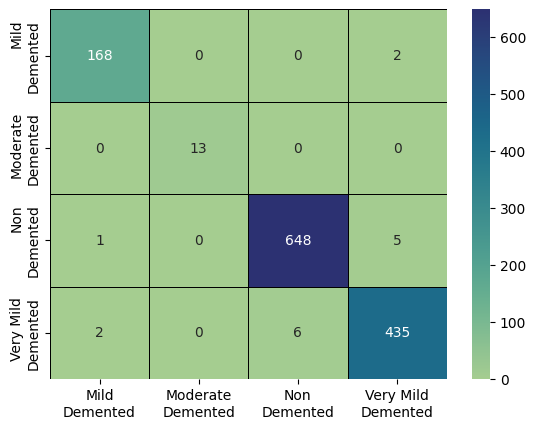

In [11]:
cm = confusion_matrix(true_labels, predictions_final)
ax = sns.heatmap(data=cm, annot=True, cmap='crest', fmt='g', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, linecolor='black', linewidth=0.5)
fig = ax.get_figure()
fig.savefig('confusion-matrix.pdf', bbox_inches='tight')

In [12]:
print(classification_report(true_labels, predictions_final))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       170
           1       1.00      1.00      1.00        13
           2       0.99      0.99      0.99       654
           3       0.98      0.98      0.98       443

    accuracy                           0.99      1280
   macro avg       0.99      0.99      0.99      1280
weighted avg       0.99      0.99      0.99      1280



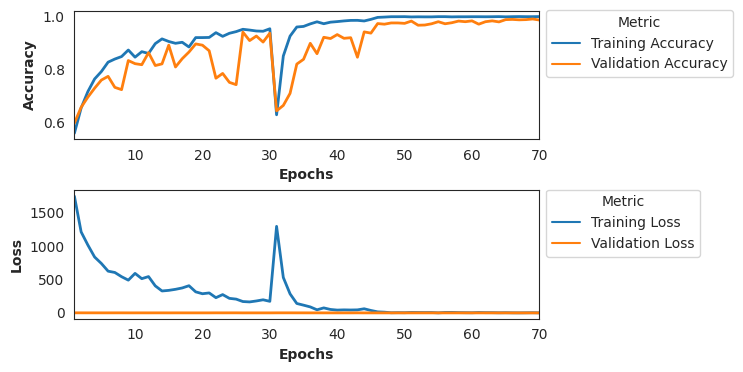

In [13]:
sns.set_style("white")
final_results = pd.concat([results, results_unfrozen, results_unfrozen_low_lr, results_unfrozen_low_lr_final], ignore_index=True).reset_index()
final_results.columns = ["Epochs", "Training Accuracy", "Validation Accuracy", "Training Loss", "Validation Loss"]
final_results["Epochs"] += 1
melted_results = pd.melt(final_results, id_vars=['Epochs'], var_name='Metric', value_name='Value')

fig = plt.figure(figsize=(6,4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(2, 1, 1)
ax = sns.lineplot(data=melted_results[melted_results["Metric"].isin(["Training Accuracy", "Validation Accuracy"])], y="Value", x="Epochs", hue="Metric", linewidth = 2, ax=ax)
ax.set_xlabel("Epochs", fontdict={'weight': 'bold'})
ax.set_ylabel("Accuracy", fontdict={'weight': 'bold'})
ax.margins(x=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.06))

ax = fig.add_subplot(2, 1, 2)
ax = sns.lineplot(data=melted_results[melted_results["Metric"].isin(["Training Loss", "Validation Loss"])], y="Value", x="Epochs", hue="Metric", linewidth = 2, ax=ax)
ax.set_xlabel("Epochs", fontdict={'weight': 'bold'})
ax.set_ylabel("Loss", fontdict={'weight': 'bold'})
ax.margins(x=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.06))

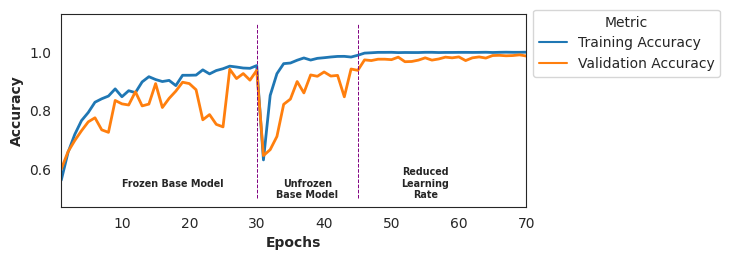

In [14]:
fig, ax = plt.subplots(figsize=(6,2.5))
ax = sns.lineplot(data=melted_results[melted_results["Metric"].isin(["Training Accuracy", "Validation Accuracy"])], y="Value", x="Epochs", hue="Metric", linewidth = 2, ax=ax)
ax.set_xlabel("Epochs", fontdict={'weight': 'bold'})
ax.set_ylabel("Accuracy", fontdict={'weight': 'bold'})
ax.margins(x=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.06))
plt.vlines(x = 30, ymin = 0.5, ymax = 1.1, colors = 'purple', linestyles='dashed', linewidth=0.7)
plt.text(10, 0.55, "Frozen Base Model", verticalalignment='center', fontdict={'fontsize': 'x-small', 'fontweight': 'bold'})
plt.vlines(x = 45, ymin = 0.5, ymax = 1.1, colors = 'purple', linestyles='dashed', linewidth=0.7)
plt.text(37.5, 0.5, "Unfrozen\nBase Model", horizontalalignment='center', fontdict={'fontsize': 'x-small', 'fontweight': 'bold'})
plt.text(55, 0.5, "Reduced\nLearning\nRate", horizontalalignment='center', fontdict={'fontsize': 'x-small', 'fontweight': 'bold'})
plt.savefig('efficient-ad-training-accuracy.pdf', bbox_inches='tight')

In [15]:
model.save("Efficient-AD.keras")